In [1]:
#%reset -f
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import dask as da
import glob
import time
from datetime import datetime, timedelta as delta
from matplotlib import path
from matplotlib.collections import PolyCollection #for plots polygons as rasters
#for animation
import matplotlib.animation as animation
from copy import deepcopy
import matplotlib as mpl
import time
import tqdm #to see progressbar for loops
from scipy.spatial import KDTree, cKDTree #c implementation is faster (to find neighbor)
%matplotlib inline
# to see the plot labels when using jupyter-lab dark mode
from matplotlib import style
#style.use('classic') #like matlab style (gray background, but white when saving figures)
#style.use('ggplot')
style.use('default') #the above styles problems with PolyCollection 
#print(style.available) #to see the styles 
import pickle #to save data as binary file .pkl
from windrose import WindroseAxes
import seaborn as sns #for heat maps of correlation and RMSD
from itertools import product #to make all possible permutations including repeated values
#
from scipy.interpolate import griddata #interpolation in space for non-uniform grids
from scipy.interpolate import interp1d #1d interp
#
import xesmf as xe #for spatial interpolation in projected or lon-lat coords

#for projections
from pyproj import Proj, transform, Transformer

In [2]:
#run this cell just once

#from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster 
#mem_limit is for each worker 
#all ways below are the same
#client = Client(processes=False, memory_limit='8GB') #process=False: 1 proccess so 1 worker and cores default (8)
#client = Client(processes=False,threads_per_worker=8,memory_limit='8GB')
#client = Client(n_workers=1,threads_per_worker=8,memory_limit='8GB')
#
#this seems that is working---
client = Client(processes=False,n_workers=1,threads_per_worker=40,memory_limit='65GB')
#this produce memory limit problems:
#client = Client(processes=False,n_workers=12,threads_per_worker=1,memory_limit='4GB')
#
#this seems that is working, but with lots of warnings related to mem issues?---
#this produce the same result as Client, but we can'not see progress neither strem
#client = LocalCluster(processes=False,n_workers=1,threads_per_worker=24,memory_limit='48GB')
#
#this is not calling any partition, just running with 1 core in the node we are now---
#cluster = SLURMCluster(queue='normal',cores=24,memory='48GB',processes=1,interface="lo")
#cluster = SLURMCluster(queue='LMEM1',cores=2,memory='1GB',project='test',interface='lo',scheduler_options={'interface': 'lo'})
#cluster = SLURMCluster(queue='LMEM1',cores=4,memory='2GB',processes=1, interface='lo')
#cluster = SLURMCluster()
#cluster.scale(jobs=2)
#cluster.scale(memory='2GB')
#cluster.adapt(maximum_jobs=2)
#print(cluster.job_script())
#client = Client(cluster)
#
client

# open dashboard with this if link doesn't work
# http://localhost:8787/status

Client Scheduler: inproc://192.168.10.61/187191/1 Dashboard: http://192.168.10.61:8787/status,Cluster Workers: 1 Cores: 40 Memory: 60.54 GiB


In [3]:
home_dir="/export/lv4/user/jfajardourbina/"
ml_dir=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/machine_learning_github/Lagrangian_ML/"
dir_winds=f"{home_dir}dws_ulf_getm_2D_depth_avg/data/atmosphere/" #winds
dir_displacement="net_displacement/"
dir_topo=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_bathy_grid/" #topo data
dir_dws_bound=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_dws_boundaries/" #DWS boundarie with contour0
#dir_vel=f"{home_dir}dws_ulf_getm_2D_depth_avg/data/velocity/" #vel data
year=1991; file_winds=f"UERRA.{year}.nc4" #to make some simple test
file_dws_bound0="dws_boundaries_contour0.nc"
file_topo="DWS200m.2012.v03.nc"
#file_vel="RE.DWS200m.uvz.20090301.nc"
#
savee='everyM2' #saving track data every m2
deploy='everyM2'#deploy set of particles every m2
minTsim=60 #mimimum time of simulation (days)
maxTsim=91 #maximum time of simulation (days)
dir_tracks = f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/exp-deployHighVolume_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d/tracks/"
#
npa_per_dep=12967 #number of particles per deployment
m2=int(12.42*3600+2) #period in seconds
ref_time=np.datetime64("1980-01-01") #reference time for time interpolation, could be any value
dx=400/1e3;dy=400/1e3 #particle grid resolution
#
#outputs
dir_post_proc_data=f"{ml_dir}post_proc_data/" #to save wind interp files
file_interp_wind=f'{year}_wind_data_every_m2_in_positions_of_deployments.nc'

In [4]:
%%time
dsw=xr.open_dataset(dir_winds+file_winds,chunks={'time':-1,'lon':-1,'lat':-1})[["u10","v10"]] #winds
#dsw=xr.open_dataset(dir_winds+file_winds)[["u10","v10"]].load() #winds
tw = dsw.time.values #contains data for the full 1st day of the next year
#del these long attributes
del dsw.attrs["history_of_appended_files"], dsw.attrs["history"]

dsto=xr.open_dataset(dir_topo+file_topo) #topo file
xct0=dsto.xc.min().values/1e3; yct0=dsto.yc.min().values/1e3 #=(0,0)

dsb0=xr.open_dataset(dir_dws_bound+file_dws_bound0) 
bdr_dws0=dsb0.bdr_dws.values #points that define DWS with contour0

#open vel data
#dsv=xr.open_dataset(dir_vel+file_vel)
#xcv=dsv.xc; ycv=dsv.yc; hv=dsv.bathymetry.load()
#xcv0=xcv.min().values/1e3; ycv0=ycv.min().values/1e3

CPU times: user 60.2 ms, sys: 4.75 ms, total: 64.9 ms
Wall time: 66.3 ms


In [5]:
#open first and last track---
#the last track should be the first of the following year
#so we can compute the avg wind on the interval of the last net displacement
month_sim=1
file_track=f'tracks_{year}{month_sim:02d}_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d.nc'
file_track_path=f'{dir_tracks}{year}/{file_track}'  
dst=xr.open_dataset(file_track_path)
t0=dst.time.isel(traj=0,obs=0).values 
x0=dst.x.isel(traj=range(npa_per_dep),obs=0).values
y0=dst.y.isel(traj=range(npa_per_dep),obs=0).values
del dst
#
month_sim=1
file_track=f'tracks_{year+1}{month_sim:02d}_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d.nc'
file_track_path=f'{dir_tracks}{year+1}/{file_track}'  
t1=xr.open_dataset(file_track_path).time.isel(traj=0,obs=0).values
#print(t0,t1)

In [6]:
#times to get wind data for this year---
#however if we can not find a factor "nt_interp" of m2, use 10min
#we wont have the same amount of interp data every m2, but the error will be just around 10min instead of 1h(original data)
nt_interp=283*2 #get wind data every 9.43 min (divisor of m2=44714)
t_interp=np.arange(t0,t1+np.timedelta64(1,'s'),nt_interp,dtype='datetime64[s]') #data until next year (to make avg during the interval of net displacement)
t_dep=np.arange(t0,t1,m2,dtype='datetime64[s]') #only for this year. Times of displacement, referenced to the initial time of the m2 interval.

In [7]:
#open grid of displacements (use for convlstm)---
file_displacement=sorted(glob.glob(f'{dir_post_proc_data}{dir_displacement}*.nc',recursive=True))[0]
ds_dis=xr.open_dataset(file_displacement); ds_dis.close()
xcdis0,ycdis0=ds_dis.x,ds_dis.y; del ds_dis
xcdis,ycdis=np.meshgrid(xcdis0,ycdis0)
#
#or build it---
#xmin=x0.min();xmax=x0.max();ymin=y0.min();ymax=y0.max()
#extend_grid=10 #so from particle min max positions extend grid 10*dx (to not have problems with convolution)
#xgrid=np.arange(xmin-dx*1e3*extend_grid,xmax+dx*1e3*(extend_grid+1),dx*1e3,dtype='float32')
#ygrid=np.arange(ymin-dy*1e3*extend_grid,ymax+dy*1e3*(extend_grid+1),dy*1e3,dtype='float32')
#xgrid,ygrid=np.meshgrid(xgrid,ygrid)

In [8]:
#define the transformations----------
#1)
#from epgs:28992(DWS) to epgs:4326(LatLon with WGS84 datum used by GPS and Google Earth)
proj = Transformer.from_crs('epsg:28992','epsg:4326',always_xy=True)
#2)
#from epgs:4326(LatLon with WGS84) to epgs:28992(DWS) 
inproj = Transformer.from_crs('epsg:4326','epsg:28992',always_xy=True)
#inproj_old=Proj("EPSG:28992") #old method (has errors 10-20m when contrast with the rotated coords)

#lon,lat to 28992(DWS)-projection--------------------

#bathymetry--------
xct=dsto.lonc.values;  yct=dsto.latc.values #lon,lat units
xctp,yctp,z = inproj.transform(xct,yct,xct*0.)
#[xctp,yctp] = inproj_old(xct,yct) #old method
xctp=(xctp)/1e3; yctp=(yctp)/1e3 
#first projected point to correct the coordinates of model local meter units
xctp0=xctp[0,0]; yctp0=yctp[0,0]

#wind original 1h-data--------
#use the full domain---
#usually problems when using local projection for big domains, but for our case no problems
xcw,ycw=np.meshgrid(dsw.lon.values,dsw.lat.values)
xcwp,ycwp,z = inproj.transform(xcw,ycw,xcw*0.)
xcwp=xcwp/1e3; ycwp=ycwp/1e3
#xcw=(xcw-xcw[0,0])/1e3; ycw=(ycw-ycw[0,0])/1e3
#use a short domain around DWS---
xcw2,ycw2=np.meshgrid(dsw.lon.sel(lon=slice(4,6.5)).values,dsw.lat.sel(lat=slice(52.5,53.75)).values)
xcwp2,ycwp2,z = inproj.transform(xcw2,ycw2,xcw2*0.)
xcwp2=(xcwp2)/1e3; ycwp2=(ycwp2)/1e3


#local meter model units to 28992(DWS)-projection and lon-lat--------------

#matrix rotation -17degrees-----
ang=-17*np.pi/180
angs=np.ones((2,2))
angs[0,0]=np.cos(ang); angs[0,1]=np.sin(ang)
angs[1,0]=-np.sin(ang); angs[1,1]=np.cos(ang)

#bathymetry----
#original topo points in meter
xct2,yct2=np.meshgrid(dsto.xc.values,dsto.yc.values)
xy=np.array([xct2.flatten(),yct2.flatten()]).T
#rotate
xyp=np.matmul(angs,xy.T).T/1e3
xyp0=xyp[0,:] #the first rotated point in the topo data in meter =0,0
#correction from rotation to projection:
#1)substact the first rotated topo point in meter, but give tha same as xyp0=[0,0]
#2)add the first projected point of the case (lon,lat model units to projection)
xyp=xyp-xyp0 
xyp[:,0]=xyp[:,0]+xctp0; xyp[:,1]=xyp[:,1]+yctp0 
xyp=np.reshape(xyp,(len(dsto.yc.values),len(dsto.xc.values),2))
xctp2=xyp[...,0]; yctp2=xyp[...,1] #km
#
#contrast projections (lon,lat model units to meter) with rotated case
#around 0 meter diff with new method
#10 meter difference in average and maximum of 20 with old method
a=xctp-xctp2; b=yctp-yctp2
print(np.abs(a).max()*1e3, np.abs(b).max()*1e3, np.abs(a).mean()*1e3, np.abs(b).mean()*1e3) 

#contour0 of DWS------
#rotate
bdr_dws0p=np.matmul(angs,bdr_dws0.T).T/1e3
#correction from rotation to projection:
#1)substact the first rotated topo point in meter, but give tha same as xyp0=[0,0]
#2)add the first projected point of the case (lon,lat model units to meter)
bdr_dws0p=bdr_dws0p-xyp0 
bdr_dws0p[:,0]=bdr_dws0p[:,0]+xctp0; bdr_dws0p[:,1]=bdr_dws0p[:,1]+yctp0
#
#get coordinates in lon-lat units (WGS84 ) 
bdr_dws0_lon, bdr_dws0_lat, z = proj.transform(bdr_dws0p[:,0]*1e3,bdr_dws0p[:,1]*1e3, bdr_dws0p[:,1]*0.)

#particle grid of displacements (use for convlstm)------
xy=np.array([xcdis.flatten(),ycdis.flatten()]).T
ny,nx=xcdis.shape
#rotate
xyp=np.matmul(angs,xy.T).T/1e3
#correction from rotation to projection:
#1)substact the first rotated topo point in meter, but give tha same as xyp0=[0,0]
#2)add the first projected point of the case (lon,lat model units to meter)
xyp=xyp-xyp0 
xyp[:,0]=xyp[:,0]+xctp0; xyp[:,1]=xyp[:,1]+yctp0 
xyp=np.reshape(xyp,(ny,nx,2))
xcdisp=xyp[...,0]; ycdisp=xyp[...,1] #km
#
#get coordinates in lon-lat units (WGS84 ) 
xcdisp_lon, ycdisp_lat, _ = proj.transform(xcdisp*1e3,ycdisp*1e3, ycdisp*0.)


#28992(DWS)-projection to local meter model units--------------

#matrix rotation 17degrees-----
ang2=17*np.pi/180
angs2=np.ones((2,2))
angs2[0,0]=np.cos(ang2); angs2[0,1]=np.sin(ang2)
angs2[1,0]=-np.sin(ang2); angs2[1,1]=np.cos(ang2)

#batymetry---
xy=np.array([xctp.flatten(),yctp.flatten()]).T #km
ny,nx=xctp.shape
#rotate
xyl=np.matmul(angs2,xy.T).T
xyl0=xyl[0,:] #the first point 
#correction from rotation to projection:
#1)substact the first rotated topo point in meter
#2)add the first local model point of the topo file
xyl=xyl-xyl0 
xyl[:,0]=xyl[:,0]+xct0; xyl[:,1]=xyl[:,1]+yct0 
xyl=np.reshape(xyl,(ny,nx,2))
xctl=xyl[...,0]; yctl=xyl[...,1] #km
#
#errors in the position when using the local values get from transformation (around 0.1% of the grid size)
a=abs(xctl*1e3-dsto.xc.values)
b=abs(yctl.T*1e3-dsto.yc.values)
print('max, mean, max% errors in x (m)',a.max(), a.mean(), a.max()/200*100,"%") # max=12cm, mean=5cm
print('max, mean, max% errors in y (m)',b.max(), b.mean(), b.max()/200*100,"%") # max=32cm, mean=13cm

#original wind---
xy=np.array([xcwp.flatten(),ycwp.flatten()]).T #km
ny,nx=xcwp.shape
#rotate
xyl=np.matmul(angs2,xy.T).T 
#correction from rotation to projection:
#1)substact the first rotated topo point in meter
#2)add the first local model point in meter of the topo file
xyl=xyl-xyl0 
xyl[:,0]=xyl[:,0]+xct0; xyl[:,1]=xyl[:,1]+yct0 
xyl=np.reshape(xyl,(ny,nx,2))
xcwl=xyl[...,0]; ycwl=xyl[...,1] #km


#local meter model units to 28992(DWS)-projection and lon-lat--------------

#select mid point of texel-------
xymid=np.expand_dims(dsb0.tr_dws_marsdiep[len(dsb0.tr_dws_marsdiep)//2].values,1).T
xymidp=np.matmul(angs,xymid.T).T/1e3 #rotate
#correct model units
xymidp=xymidp-xyp0; xymidp[:,0]=xymidp[:,0]+xctp0; xymidp[:,1]=xymidp[:,1]+yctp0
#get coordinates in lon-lat units (WGS84) 
xymidp_lon, xymidp_lat, z = proj.transform(xymidp[:,0]*1e3,xymidp[:,1]*1e3, xymidp[:,1]*0.)
#find nearest point for wind--------
ixt=np.argmin(abs(dsw.lon.values-xymidp_lon))+1 #to consider the point inside DWS (the nearest is outside) 
iyt=np.argmin(abs(dsw.lat.values-xymidp_lat))
#lon diff 0.08 (around 10 km difference, approx reso of wind data)
#print(xymidp_lon, dsw.lon[ixt].values, xymidp_lat, dsw.lat[iyt].values)

#select a point close to vlie-------
xymid=np.expand_dims(dsb0.tr_dws_vlie[0,:].values,1).T
xymidp=np.matmul(angs,xymid.T).T/1e3 #rotate
#correct model units
xymidp=xymidp-xyp0; xymidp[:,0]=xymidp[:,0]+xctp0; xymidp[:,1]=xymidp[:,1]+yctp0
#get coordinates in lon-lat units (WGS84) 
xymidp_lon, xymidp_lat, z = proj.transform(xymidp[:,0]*1e3,xymidp[:,1]*1e3, xymidp[:,1]*0.)
#find nearest point for wind--------
ixv=np.argmin(abs(dsw.lon.values-xymidp_lon)); iyv=np.argmin(abs(dsw.lat.values-xymidp_lat))
#lon diff 0.08 (around 10 km difference, approx reso of wind data)
#print(xymidp_lon, dsw.lon[ixv].values, xymidp_lat, dsw.lat[iyv].values)

#eastern DWS (low mean)-------
xymidp_lat=53.4; xymidp_lon=5.8
ixedw=np.argmin(abs(dsw.lon.values-xymidp_lon)); iyedw=np.argmin(abs(dsw.lat.values-xymidp_lat))
#lon diff 0.08 (around 10 km difference, approx reso of wind data)
#print(xymidp_lon, dsw.lon[ixedw].values, xymidp_lat, dsw.lat[iyedw].values)


#computing wind resolution in km along zonal and meridional directions----------
#using projection obtained from lon-lat--
print()
print("original wind spatial resolution:")
dwpx=np.gradient(xcwp,axis=1); dwpy=np.gradient(ycwp,axis=0)
print(f"along zonal direction: min={dwpx.min():.2f}km ,mean={dwpx.mean():.2f}km ,max={dwpx.max():.2f}km")
print(f"along meridional direction: min={dwpy.min():.2f}km ,mean={dwpy.mean():.2f}km ,max={dwpy.max():.2f}km")
#using lon-lat to get distance from spherical coords--
dwlon=np.diff(dsw.lon.values).mean() #=cte=0.22deg
dwlat=np.diff(dsw.lat.values).mean() #=cte=0.11deg
dwlonx=6371*np.pi/180*dwlon*np.cos(dsw.lat.values.mean()*np.pi/180) #km
dwlaty=6371*np.pi/180*dwlat #km = 111.2*dlat
print(f"Using eq from spherical coords: dlon={dwlon:.2f}deg, dlat={dwlat:.2f}deg, mean(dlon)={dwlonx:.2f}km, dlat={dwlaty:.2f}km") 

0.026940217722426496 0.3400088997977946 0.009365292291273685 0.1443332403121348
max, mean, max% errors in x (m) 0.12412859736627979 0.04687436167418282 0.062064298683139896 %
max, mean, max% errors in y (m) 0.32751821742022 0.13691407317063156 0.16375910871011 %

original wind spatial resolution:
along zonal direction: min=13.39km ,mean=14.43km ,max=15.44km
along meridional direction: min=12.22km ,mean=12.24km ,max=12.27km
Using eq from spherical coords: dlon=0.22deg, dlat=0.11deg, mean(dlon)=14.39km, dlat=12.23km


In [1]:
#create mask for islands
#h=dsto.bathymetry; mask=h.where(np.isnan(h),1); mask=mask.where(np.isfinite(h),0)

/tmp/ipykernel_138767/4276463299.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  aa=ax[1].pcolormesh(xcwp,ycwp,ws_avg.values,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation


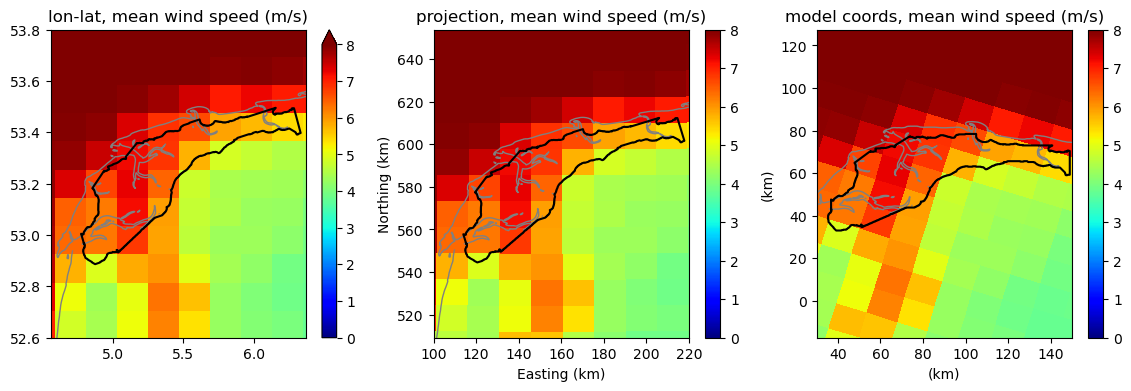

In [12]:
fig,ax= plt.subplots(1,3,figsize=(14,4))

ws=(dsw.u10**2+dsw.v10**2)**.5
ws_avg=ws.mean(dim='time') #avg for 2009

ws_avg.plot.pcolormesh(ax=ax[0],vmin=0,vmax=8,shading='auto',cmap='jet')#wind-energy lon-lat
ax[0].contour(xct,yct,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy in lon-lat from topo file 
ax[0].plot(bdr_dws0_lon,bdr_dws0_lat,'k') #DWS limits in lon-lat
ax[0].axis([4.56,6.37,52.6,53.8]);ax[0].set_xlabel('');ax[0].set_ylabel('')
ax[0].set_title('lon-lat, mean wind speed (m/s)')
#
aa=ax[1].pcolormesh(xcwp,ycwp,ws_avg.values,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1].axis('equal');ax[1].axis([100,220,543,620])
ax[1].set_xlabel('Easting (km)');ax[1].set_ylabel('Northing (km)');
ax[1].set_title('projection, mean wind speed (m/s)');
plt.colorbar(aa,ax=ax[1])
#
aa=ax[2].pcolormesh(xcwl,ycwl,ws_avg.values,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation
ax[2].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[2].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k') #DWS limits
ax[2].axis('equal');ax[2].axis([30,150,30,80])
ax[2].set_xlabel('(km)');ax[2].set_ylabel('(km)');
ax[2].set_title('model coords, mean wind speed (m/s)');
plt.colorbar(aa,ax=ax[2])

### Get uw and vw interpolated in particle grid points (with xarray for time and xesmf for space)

#### Spatial interpolation

In [11]:
#spatial interpolation using lon-lat---

#build the input grid (lon-lat of original wind file)---
ds_in = xr.Dataset()
ds_in.coords["lon"] = dsw.lon.astype('float32')
ds_in["lon"].attrs['long_name'] = 'longitude'
ds_in.coords["lat"] = dsw.lat.astype('float32')
ds_in["lat"].attrs['long_name'] = 'latidude'
print(ds_in)
print()

#build the output grid (lon-lat of particle displacement)---
#this gris is used for the interpolation
ds_out = xr.Dataset()
ds_out.coords["lon"] = (("yc","xc"),xcdisp_lon.astype('float32'))
ds_out["lon"].attrs['long_name'] = 'longitude'
ds_out.coords["lat"] = (("yc","xc"),ycdisp_lat.astype('float32'))
ds_out["lat"].attrs['long_name'] = 'latidude'
#ds_out=ds_out.drop(["xc","yc"])
print(ds_out)

<xarray.Dataset>
Dimensions:  (lon: 38, lat: 55)
Coordinates:
  * lon      (lon) float32 2.5 2.72 2.94 3.16 3.38 ... 9.98 10.2 10.42 10.64
  * lat      (lat) float32 51.0 51.11 51.22 51.33 ... 56.61 56.72 56.83 56.94
Data variables:
    *empty*

<xarray.Dataset>
Dimensions:  (yc: 133, xc: 304)
Coordinates:
    lon      (yc, xc) float32 4.783 4.789 4.794 4.8 ... 6.273 6.278 6.284 6.29
    lat      (yc, xc) float32 52.84 52.84 52.84 52.84 ... 53.6 53.6 53.6 53.61
Dimensions without coordinates: yc, xc
Data variables:
    *empty*


In [12]:
%%time
#only need to run once
regridder = xe.Regridder(ds_in,ds_out,"patch") #special smooth from this package
#regridder_bilinear = xe.Regridder(ds_in,ds_out,"bilinear")
#regridder_nearest = xe.Regridder(ds_in,ds_out,"nearest_s2d") #classical nearest

CPU times: user 4.35 s, sys: 163 ms, total: 4.51 s
Wall time: 4.17 s


In [13]:
%%time
#patch = 20s loading data into mem
dsw_int_patch = regridder(dsw)
#dsw_int_bilinear = regridder_bilinear(dsw)
#dsw_int_nearest = regridder_nearest(dsw)
#convert to float32
#dsw_int_patch["u10"].values=dsw_int_patch["u10"].values.astype('float32')
#dsw_int_patch["v10"].values=dsw_int_patch["v10"].values.astype('float32')

CPU times: user 18.7 ms, sys: 971 µs, total: 19.6 ms
Wall time: 18.5 ms


/export/lv4/user/jfajardourbina/programs/miniconda3/envs/phd_parcelsv221/lib/python3.8/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [13]:
#verify that the result is the same as regridding each variable one-by-one
#for k in dsw_int_mean.data_vars: print(k, dsw_int_mean_regrid_bilinear[k].equals(regridder_bilinear(dsw_int_mean[k])))

In [18]:
#mean speed for 1990---
#ws_original=((dsw.u10**2+dsw.v10**2)**.5).mean(dim='time')
#ws_nearest=((dsw_int_nearest.u10**2+dsw_int_nearest.v10**2)**.5).mean(dim="time")
#ws_bilinear=((dsw_int_bilinear.u10**2+dsw_int_bilinear.v10**2)**.5).mean(dim="time")
#ws_patch=((dsw_int_patch.u10**2+dsw_int_patch.v10**2)**.5).mean(dim="time")

/tmp/ipykernel_130979/913737817.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  aa=ax[0,0].pcolormesh(xcwp,ycwp,ws_original,vmin=4,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation


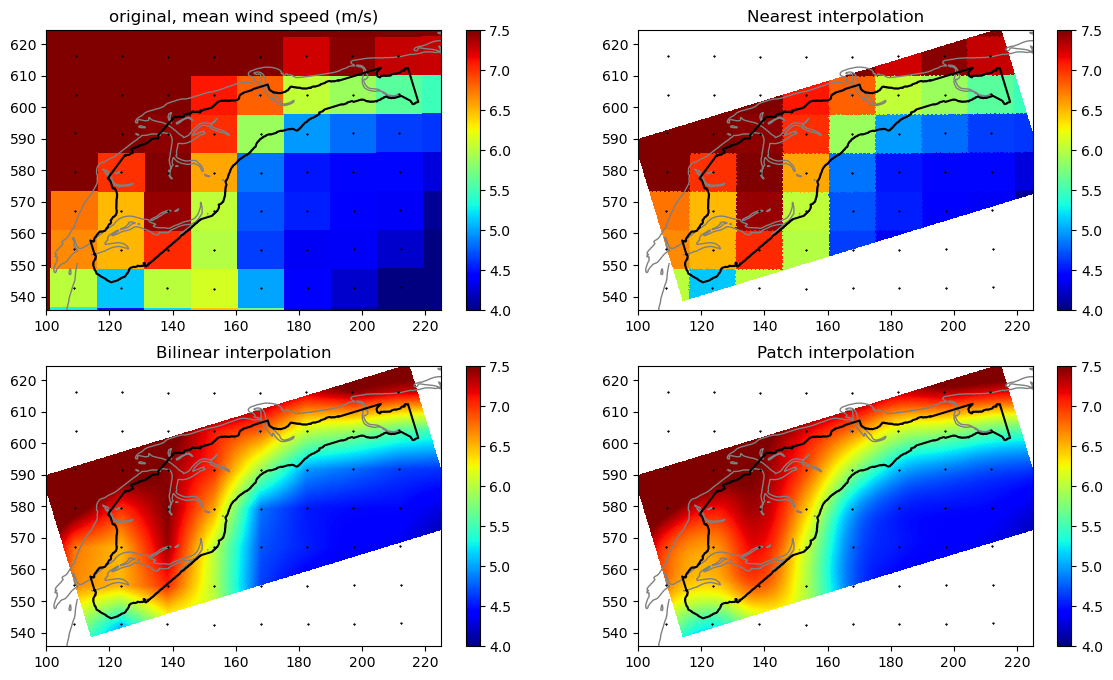

In [19]:
fig,ax= plt.subplots(2,2,figsize=(14,8))

a=xcwp.flatten();b=ycwp.flatten()

aa=ax[0,0].pcolormesh(xcwp,ycwp,ws_original,vmin=4,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[0,0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0,0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0,0].axis('equal');ax[0,0].axis([100,225,540,620])#;ax[0,0].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[0,0])
ax[0,0].plot(a,b,'*k',ms=1)
ax[0,0].set_title('original, mean wind speed (m/s)')
#
aa=ax[0,1].pcolormesh(xcdisp,ycdisp,ws_nearest,vmin=4,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[0,1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0,1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0,1].axis('equal');ax[0,1].axis([100,225,540,620])#;ax[0,1].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[0,1])
ax[0,1].plot(a,b,'*k',ms=1)
ax[0,1].set_title('Nearest interpolation');
#
aa=ax[1,0].pcolormesh(xcdisp,ycdisp,ws_bilinear,vmin=4,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[1,0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1,0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1,0].axis('equal');ax[1,0].axis([100,225,540,620])#;ax[1,0].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[1,0])
ax[1,0].plot(a,b,'*k',ms=1)
ax[1,0].set_title('Bilinear interpolation');
#
aa=ax[1,1].pcolormesh(xcdisp,ycdisp,ws_patch,vmin=4,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[1,1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1,1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1,1].axis('equal');ax[1,1].axis([100,225,540,620])#;ax[1,1].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[1,1])
ax[1,1].plot(a,b,'*k',ms=1)
ax[1,1].set_title('Patch interpolation');

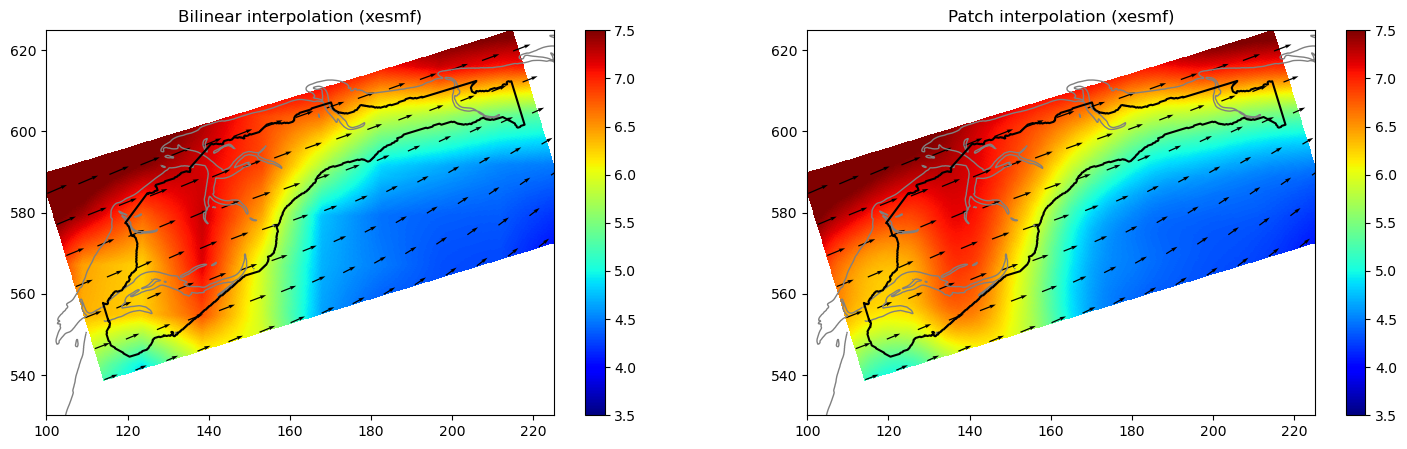

In [54]:
#check above for the avg---
#u10blm=np.mean(dsw_int_bilinear.u10,axis=0);v10blm=np.mean(dsw_int_bilinear.v10,axis=0)
#u10pm=np.mean(dsw_int_patch.u10,axis=0);v10pm=np.mean(dsw_int_patch.v10,axis=0)
#
fig,ax= plt.subplots(1,2,figsize=(18,5))
iyy=20;ixx=20
units='width';width=0.0025;scale=50
aa=ax[0].pcolormesh(xcdisp,ycdisp,ws_bilinear,vmin=3.5,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0].quiver(xcdisp[::iyy,::ixx],ycdisp[::iyy,::ixx],u10blm[::iyy,::ixx],v10blm[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax[0].axis('equal');ax[0].axis([100,225,540,615])
plt.colorbar(aa,ax=ax[0])
ax[0].set_title('Bilinear interpolation (xesmf)')
aa=ax[1].pcolormesh(xcdisp,ycdisp,ws_patch,vmin=3.5,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1].quiver(xcdisp[::iyy,::ixx],ycdisp[::iyy,::ixx],u10pm[::iyy,::ixx],v10pm[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax[1].axis('equal');ax[1].axis([100,225,540,615])
plt.colorbar(aa,ax=ax[1])
ax[1].set_title('Patch interpolation (xesmf)');

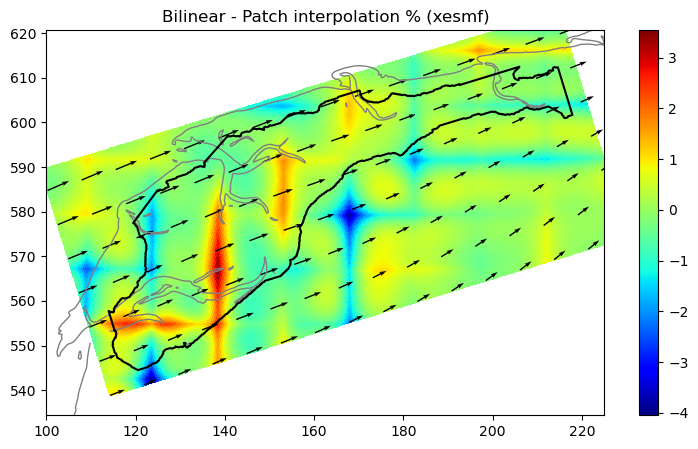

In [58]:
#difference---
fig,ax= plt.subplots(1,1,figsize=(9,5))
iyy=20;ixx=20
units='width';width=0.0025;scale=50
aa=ax.pcolormesh(xcdisp,ycdisp,(ws_bilinear-ws_patch)/ws_patch*100,shading='auto',cmap='jet') #wind correct orientation
ax.contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax.plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax.quiver(xcdisp[::iyy,::ixx],ycdisp[::iyy,::ixx],u10blm[::iyy,::ixx],v10blm[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax.axis('equal');ax.axis([100,225,540,615])
plt.colorbar(aa,ax=ax)
ax.set_title('Bilinear - Patch interpolation % (xesmf)');

#### Temporal interpolation

In [14]:
def interp1d_fun(x,tin,tout):
    f = interp1d(tin,x,axis=-1,kind='linear')
    return f(tout)

def xr_interp1d(x,tin,tout,idim,odim):
    #x: xarray with chunks
    #idim: input coordinate that will be changed by output odim
    #odim: output coordinate
    result = xr.apply_ufunc(
             interp1d_fun,x,
             input_core_dims=[[idim]],
             output_core_dims=[[odim]],
             output_dtypes=[np.float32],
             dask_gufunc_kwargs={'output_sizes':{odim:len(tout)}},
             kwargs={'tin':tin,'tout':tout}, #input to the above function
             dask='parallelized',
             #vectorize=True,
             )
    return result

In [15]:
#2 times faster with multiproc, but virtual mem is huge>300GB?
#caling pool inside a loop could not be optimal
#we are only limited to 1 node
#hope to find problems that are not I/O to get advantage of dask


# def interp1d_fun_pool(x,tin,tout):
#     #tout=(t_interp-ref_time) / np.timedelta64(1,'s')  #dates to interpolate (consistent with tracks)
#     #tin=(tw-ref_time) / np.timedelta64(1,'s') #wind
#     f = interp1d(tin,x,axis=-1,kind='linear')
#     return f(tout).mean(axis=-1)

# def xr_interp1d_pool(inp):
#     x=inp[0]; tin=inp[1]; tout=inp[2]
#     idim=inp[3]
#     #x: xarray with chunks
#     #idim: input coordinate that will be changed by output odim
#     #odim: output coordinate
#     result = xr.apply_ufunc(
#              interp1d_fun_pool,x,
#              input_core_dims=[[idim]],
#              output_dtypes=[np.float32],
#              kwargs={'tin':tin,'tout':tout}, #input to the above function
#              #dask='parallelized',
#              #vectorize=True,
#              )  
#     return result


# from multiprocessing import Pool
# from multiprocessing import cpu_count
# import time

# mean1=[]
# for i in range(304):
#     mean1.append(xr_interp1d(dsw_int_patch.isel(xc=i),tin,tout,idim='time',odim='time_int').mean(dim='time_int'))     
# mean1=xr.concat(mean1,dim="xc")


# #just 3 times faster than in serie and 2 times than dask (I think is an I/O issue)
# #we have to add for this pool case extra 25s (reading + gridding)
# if __name__ == "__main__":
#     #parallel---
#     pool = Pool(processes=40)
#     inputs=[[dsw_int_patch.isel(xc=i),tin,tout,'time'] for i in range(304)]
#     results = pool.map(xr_interp1d_pool, iterable=inputs)
#     #results = pool.map(add_1, range(10))
#     pool.close()  # 'TERM'
#     pool.join()   # 'KILL'
# mean1=xr.concat(results,dim="xc")

In [16]:
#---
#using data in memory and above ufunc: mem max 30GB, and then you use 18GB, takes around 2min

#interpolation in time with xarray-------
#use mem around 35GB, but at the end release it
#takes 2min
#dsw_int = dsw_int_patch.chunk(chunks={'time':-1,'xc':30,'yc':30})
#dsw_int = dsw_int.interp(time=t_interp,method="linear").chunk(chunks={'time':-1,'xc':20,'yc':20})
#mean=da.compute(dsw_int.mean(dim='time'))

In [17]:
tout=(t_interp-ref_time) / np.timedelta64(1,'s') #dates after interpolation (factor of m2)
tin=(tw-ref_time) / np.timedelta64(1,'s') #dates of original winds (every 1h)

In [19]:
%%time
dsw_int=xr_interp1d(dsw_int_patch.chunk({'time':-1,'xc':10,'yc':10}),tin,tout,idim='time',odim='time_int').transpose("time_int","yc","xc")#.compute()
#add time, xc and yc coords
dsw_int.coords["time_int"]=t_interp
dsw_int.coords["xc"] = ("xc",xcdis0.values.astype('float32')) #model coords in m
dsw_int.coords["yc"] = ("yc",ycdis0.values.astype('float32'))
#seems that for this example increasing cores dont improve speed
#IT SEEMS THAT THIS IS I/O BOUNDED MORE THAN CPU, because you need to create data when using interp
#the time is longer th first time you run, then decrease until 1 min. 
#1-2min with 40core, <7GB mem temporal allocation xc:5,yc:5 #5MB chunk
#1-2min with 40core, <9GB mem temporal allocation xc:15,yc:15 #50MB chunk
#1-2min with 40core, <12GB mem temporal allocation xc:30,yc:30 #200MB chunk
#1-2min with 6core, <12GB mem temporal allocation xc:30,yc:30 #200MB chunk
#1-2min with 2core, <12GB mem temporal allocation xc:30,yc:30 #200MB chunk
#mean=da.compute(dsw_int.mean(dim='time_int'))[0]

CPU times: user 24.2 ms, sys: 3.96 ms, total: 28.2 ms
Wall time: 26.5 ms


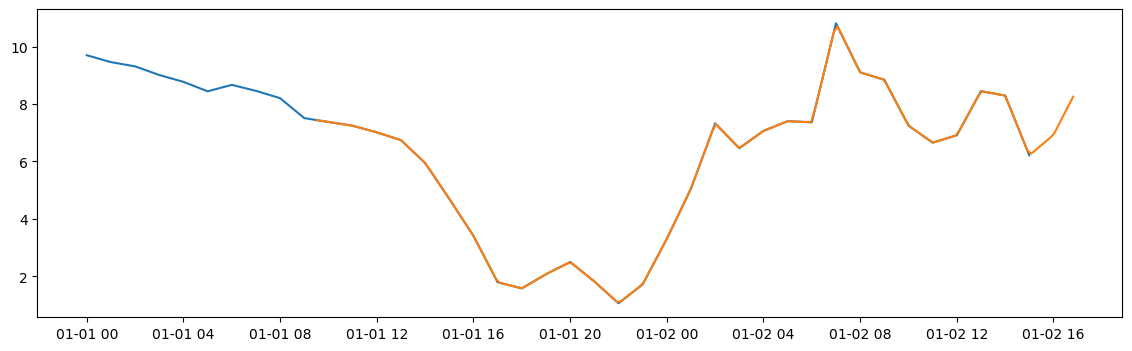

In [31]:
#check interpolation
plt.figure(figsize=(14,4))
#dsw_int_ori=dsw_int_patch.u10[:40,2,3].compute()
plt.plot(dsw.time[:40],dsw_int_ori)
plt.plot(t_interp[:200],dsw_int.u10[:200,2,3])

In [20]:
#check time dimensions---
nt_interval=int(m2/nt_interp) #points in the m2 interval (right border of interval open)
nt_dep=(len(t_interp)-1)//nt_interval #=len(t_dep), final shape after mean or std in the m2 interval. "-1" because we also don't consider the right border of the last interval in the avg
#times after avg or std are referenced with the date of deployment (the begin of the m2 interval of the displacement)
nt_interval,nt_dep,len(t_dep),nt_interval*nt_dep,len(dsw_int.time_int)-1

(79, 706, 706, 55774, 55774)

In [21]:
#https://stackoverflow.com/questions/59504320/how-do-i-subdivide-refine-a-dimension-in-an-xarray-dataset
#steps:
# - assign_coords: create coords time_dep and time_interval 
# - stack: create a coord and index called multi_time which is related to the original temporal size of the data,
#          that now match a 2d-MultiIndex(nt_dep,nt_interval) which is defined using the new time_dep and time_interval coords,
#          and will order the above coords keeping constant time_dep in every time_interval(0:78); which is consistent with how dsw_t_interp was created.
# - reset_index().rename: del the the old time coord, and rename time index as multi_time to remove the old time index.
# - unstack(): use the above 2d-MultiIndex to reshape the data original 1d time data into time_dep, time_interval,
#              however, the new dimensions are send by default to the last index, 
# - transpose: to fix above issue for the dimensions of variables, however, can not fix the order that dims are shown after Dimensions:
#
dsw_int=dsw_int.isel(time_int=slice(0,-1)
        ).assign_coords(time_dep=t_dep,time_interval=range(nt_interval)
        ).stack(multi_time=("time_dep","time_interval")
        ).reset_index("time_int",drop=True).rename(time_int="multi_time"
        ).unstack(dim="multi_time").transpose("time_dep","time_interval","yc","xc")
dsw_int #still time in the last on the title of dimensions
#
#not working for fixing above issue
# indexes = dsw_t_interp0._indexes
# new_index_order=['time_dep', 'time_interval','lat', 'lon']
# new_index_order = {k: indexes[k] for k in new_index_order}
# dsw_t_interp0._indexes=new_index_order
# dsw_t_interp0._indexes
#
#instead of above we could also try resample of xarray---
#and then perform avg, std, but not working well
#res=int(nt_interp+m2)
#dsout_m2_avg=dsout.resample(time=f'{res}s',closed="right")#.mean(dim='time');
#print(t_dep[:5])
#for i in dsout_m2_avg: print(i)

<xarray.Dataset>
Dimensions:        (yc: 133, xc: 304, time_dep: 706, time_interval: 79)
Coordinates:
    lon            (yc, xc) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    lat            (yc, xc) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
  * xc             (xc) float32 3.16e+04 3.2e+04 ... 1.524e+05 1.528e+05
  * yc             (yc) float32 2.94e+04 2.98e+04 3.02e+04 ... 8.18e+04 8.22e+04
  * time_dep       (time_dep) datetime64[ns] 2001-01-01T01:48:28 ... 2001-12-...
  * time_interval  (time_interval) int64 0 1 2 3 4 5 6 ... 72 73 74 75 76 77 78
Data variables:
    u10            (time_dep, time_interval, yc, xc) float32 dask.array<chunksize=(706, 79, 10, 10), meta=np.ndarray>
    v10            (time_dep, time_interval, yc, xc) float32 dask.array<chunksize=(706, 79, 10, 10), meta=np.ndarray>

In [ ]:
#rotate wind from projection to model coordinates---
def projection_to_model_local_coords(x,y,ang=17*np.pi/180):
    return np.cos(ang)*x + np.sin(ang)*y, -np.sin(ang)*x + np.cos(ang)*y

dsw_int["u10"],dsw_int["v10"]=projection_to_model_local_coords(dsw_int.u10,dsw_int.v10)

In [23]:
wd = np.arctan2(dsw_int.v10,dsw_int.u10) #wd for the interp times
ws = (dsw_int.u10**2 + dsw_int.v10**2)**.5 #ws for the interp times
u10_vec = dsw_int.u10.mean(dim='time_interval')
v10_vec = dsw_int.v10.mean(dim='time_interval')
#
dsw_int["wd_mean"] = np.arctan2(v10_vec,u10_vec)
dsw_int["ws_mean"] = ws.mean(dim='time_interval')
dsw_int["ws_mean_vec"] = (u10_vec**2 + v10_vec**2)**.5 
dsw_int["wd_std"] = ( (ws*(2*np.arctan(np.tan(0.5*(wd-dsw_int["wd_mean"]))))**2).mean(dim='time_interval') / dsw_int["ws_mean"] )**.5
dsw_int["ws_std"] = ( ((ws*np.cos(wd-dsw_int["wd_mean"]))**2).mean(dim='time_interval') - dsw_int["ws_mean_vec"]**2 )**.5
#
#del u10 and v10
del dsw_int["u10"], dsw_int["v10"], dsw_int["time_interval"]

In [24]:
%%time
#14min with 1 core  (25GB mem)
#2min15s with 20 cores (but around 30GB mem)
#1min47s with 40 cores (but around 35GB mem)
dsw_int=dsw_int.compute()

CPU times: user 8min 3s, sys: 2min 42s, total: 10min 45s
Wall time: 1min 47s


In [9]:
#save data---
dsw_int=dsw_int.rename(time_dep="time") #rename dim time_dep
#global coords and attrs---
dsw_int["time"].attrs['description'] = 'initial date of the M2 interval of the net particle displacement'
dsw_int["yc"].attrs['long_name'] = 'yc'
dsw_int["yc"].attrs['description'] = 'the same as the net particle displacement grid y-axis'
dsw_int["yc"].attrs['units'] = 'm'
dsw_int["xc"].attrs['long_name'] = 'xc'
dsw_int["xc"].attrs['description'] = 'the same as the net particle displacement grid x-axis'
dsw_int["xc"].attrs['units'] = 'm'
#
dsw_int.attrs["spatial_info"] = "1) xESMF (method: patch) was used to interpolate wind components to the net displacement particle-grid (using lon-lat coords). 2) Then the wind was projected (rotated) to the local model axes."    
dsw_int.attrs["temporal_info"] = f"Wind components were linearly interpolated to {nt_interp}s (factor of M2={m2}s), and then the avg and std in the M2 interval of the net displacement were computed."
dsw_int.attrs["std of wind speed and direction"] = "Based on Farrugia and Micallef (2017)."
#
#variables---
#
dsw_int["wd_mean"].attrs['long_name'] = 'M2-mean wind direction'
dsw_int["wd_mean"].attrs['units'] = 'radian'
dsw_int["wd_mean"].attrs['description'] = 'Farrugia and Micallef (2017): eq(7)'
#
dsw_int["ws_mean"].attrs['long_name'] = 'M2-mean wind speed'
dsw_int["ws_mean"].attrs['units'] = 'm/s'
dsw_int["ws_mean"].attrs['description'] = 'eq(9)'
#
dsw_int["ws_mean_vec"].attrs['long_name'] = 'M2-mean wind speed with vectorial method'
dsw_int["ws_mean_vec"].attrs['units'] = 'm/s'
dsw_int["ws_mean_vec"].attrs['description'] = 'eq(8)'
#
dsw_int["wd_std"].attrs['long_name'] = 'M2-std of wind direction'
dsw_int["wd_std"].attrs['units'] = 'radian'
dsw_int["wd_std"].attrs['description'] = 'eq(18): square root of along wind variance'
#
dsw_int["ws_std"].attrs['long_name'] = 'M2-std of wind speed'
dsw_int["ws_std"].attrs['units'] = 'm/s'
dsw_int["ws_std"].attrs['description'] = 'eq(25)'

In [2]:
#save data---
dsw_int.to_netcdf("test.nc")
del dsw_int

#open data---
dsw_int=xr.open_dataset("test.nc")

#only spatial interp (original dt=1h)--- 
dsw_int_xy=dsw_int_patch.compute()

In [10]:
# dir_post_proc_data=f"{ml_dir}post_proc_data/" #to save wind interp files
# dir_interp_wind="wind/"
# file_interp_wind_root="wind_avg_std_during_1M2_and_interp_to_particle_grid_for_convlstm.nc"
# dsw_int=xr.open_dataset(dir_post_proc_data+dir_interp_wind+"1985_"+file_interp_wind_root)

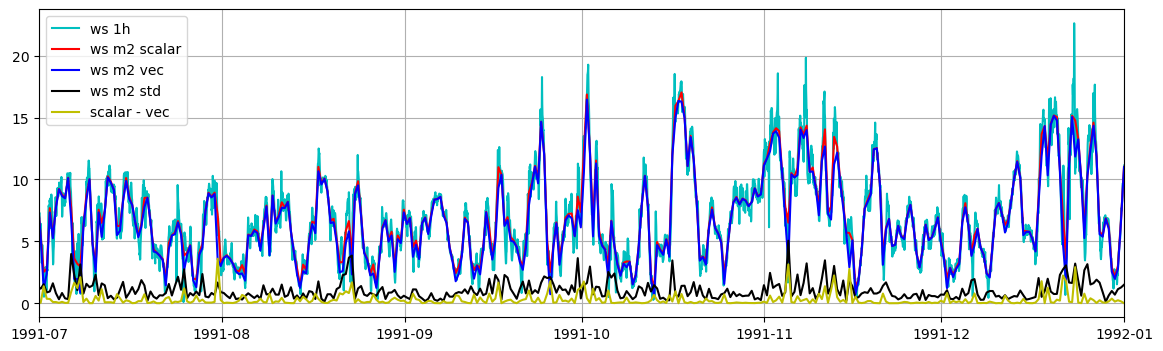

In [27]:
plt.figure(figsize=(14,4))
i=70;j=80
tt=dsw_int.time+np.timedelta64(m2//2,"s")
plt.plot(dsw_int_xy.time,((dsw_int_xy.u10[:,j,i]**2+dsw_int_xy.v10[:,j,i]**2)**.5),'c',label="ws 1h")
plt.plot(tt,dsw_int.ws_mean[:,j,i],'r',label="ws m2 scalar")
plt.plot(tt,dsw_int.ws_mean_vec[:,j,i],'b',label="ws m2 vec")
plt.plot(tt,dsw_int.ws_std[:,j,i],'k',label="ws m2 std")
plt.plot(tt,dsw_int.ws_mean[:,j,i]-dsw_int.ws_mean_vec[:,j,i],'y',label="scalar - vec")
plt.xlim(np.datetime64("1991-07"),np.datetime64("1992-01"))
plt.legend();plt.grid();

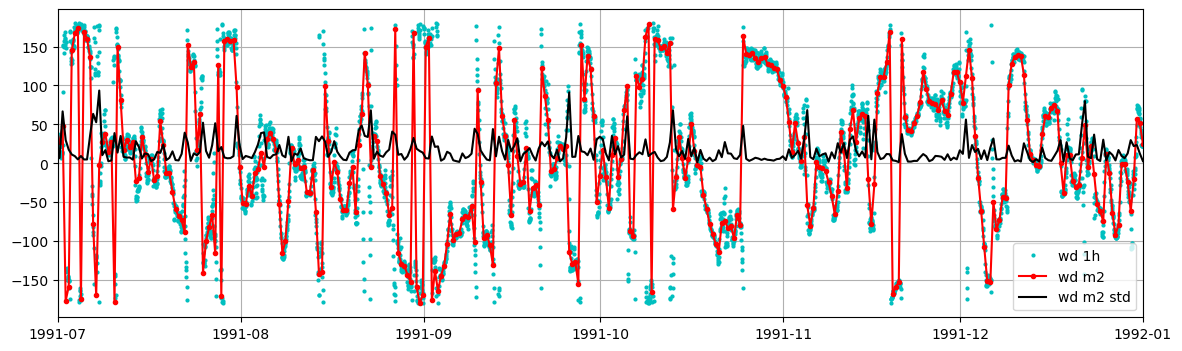

In [26]:
plt.figure(figsize=(14,4))
i=70;j=80
wdd=np.arctan2(dsw_int_xy.v10[:,j,i],dsw_int_xy.u10[:,j,i])*180/np.pi
plt.plot(dsw_int_xy.time,wdd,'oc',label="wd 1h",ms=2)
plt.plot(tt,dsw_int.wd_mean[:,j,i]*180/np.pi,'-or',label="wd m2",ms=3)
plt.plot(tt,dsw_int.wd_std[:,j,i]*180/np.pi,'-k',label="wd m2 std")
#plt.xlim(np.datetime64("1991-01-01"),np.datetime64("1991-03-01"))
#plt.xlim(np.datetime64("1991-07-01"),np.datetime64("1991-08-01"))
plt.xlim(np.datetime64("1991-07"),np.datetime64("1992-01"))
plt.legend();plt.grid();

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


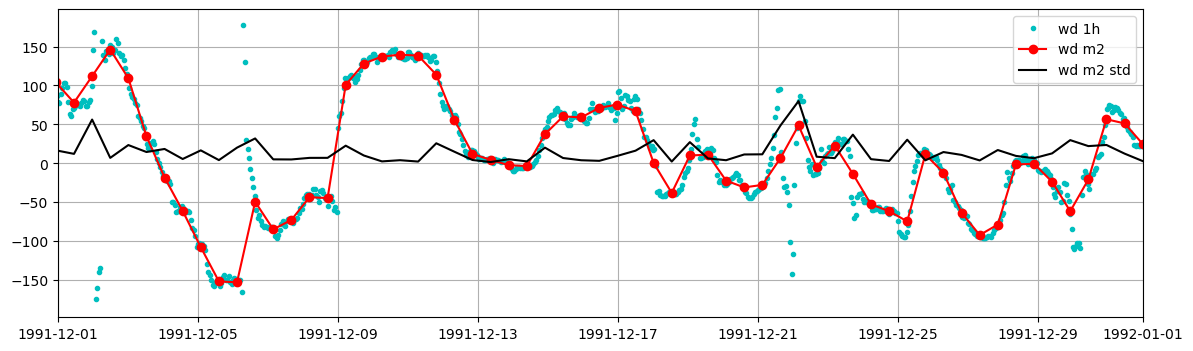

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [38]:
plt.figure(figsize=(14,4))
i=70;j=80
wdd=np.arctan2(dsw_int_xy.v10[:,j,i],dsw_int_xy.u10[:,j,i])*180/np.pi
plt.plot(dsw_int_xy.time,wdd,'oc',label="wd 1h",ms=3)
plt.plot(tt,dsw_int.wd_mean[:,j,i]*180/np.pi,'-or',label="wd m2",ms=6)
plt.plot(tt,dsw_int.wd_std[:,j,i]*180/np.pi,'-k',label="wd m2 std")
#plt.xlim(np.datetime64("1991-01-01"),np.datetime64("1991-03-01"))
plt.xlim(np.datetime64("1991-12-01"),np.datetime64("1992-01-01"))
#plt.xlim(np.datetime64("1991-07"),np.datetime64("1992-01"))
plt.legend();plt.grid();

In [26]:
#sclar--
ws_mean=dsw_int.ws_mean.mean(dim="time")
ws_mean_u10=(dsw_int.ws_mean*np.cos(dsw_int.wd_mean)).mean(dim="time")
ws_mean_v10=(dsw_int.ws_mean*np.sin(dsw_int.wd_mean)).mean(dim="time")
ws_mean_std=dsw_int.ws_std.mean(dim="time")
wd_mean_std=dsw_int.wd_std.mean(dim="time")
#wd_mean=np.arctan2(ws_mean_v10,ws_mean_u10)
#ws_mean_u10=ws_mean*np.cos(wd_mean); ws_mean_v10=ws_mean*np.sin(wd_mean)
#
#vectorial--
ws_mean_vec=dsw_int.ws_mean_vec.mean(dim="time")
ws_mean_vec_u10=(dsw_int.ws_mean_vec*np.cos(dsw_int.wd_mean)).mean(dim="time")
ws_mean_vec_v10=(dsw_int.ws_mean_vec*np.sin(dsw_int.wd_mean)).mean(dim="time")

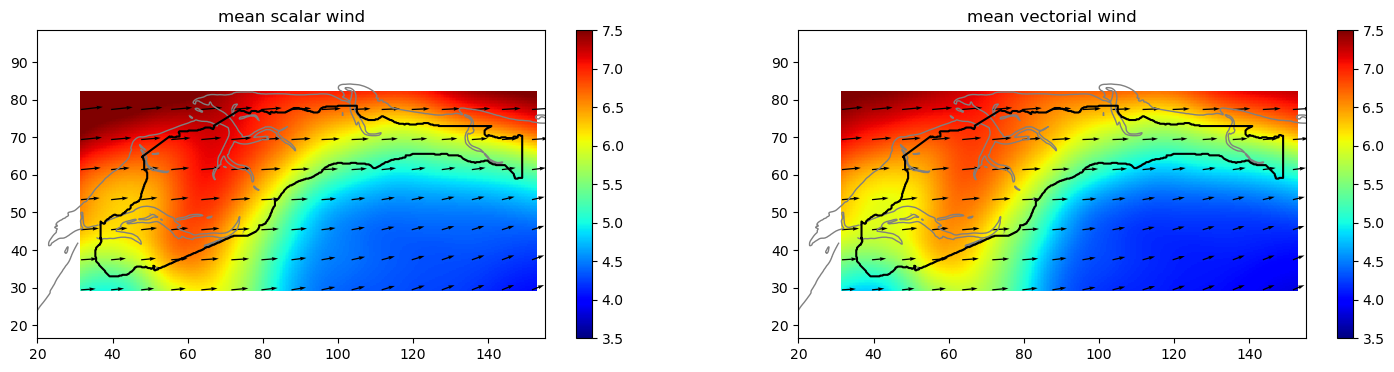

In [86]:
#check above for the avg---
#
fig,ax= plt.subplots(1,2,figsize=(18,4))
iyy=20;ixx=20
units='width';width=0.0025;scale=50
aa=ax[0].pcolormesh(xcdis0/1e3,ycdis0/1e3,ws_mean,vmin=3.5,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[0].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k') #DWS limits
Q=ax[0].quiver(xcdis[::iyy,::ixx]/1e3,ycdis[::iyy,::ixx]/1e3,ws_mean_u10[::iyy,::ixx],ws_mean_v10[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax[0].axis('equal');ax[0].axis([20,155,30,85])
plt.colorbar(aa,ax=ax[0])
ax[0].set_title('mean scalar wind')
aa=ax[1].pcolormesh(xcdis0/1e3,ycdis0/1e3,ws_mean_vec,vmin=3.5,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[1].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k') #DWS limits
ax[1].quiver(xcdis[::iyy,::ixx]/1e3,ycdis[::iyy,::ixx]/1e3,ws_mean_vec_u10[::iyy,::ixx],ws_mean_vec_v10[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax[1].axis('equal');ax[1].axis([20,155,30,85])
plt.colorbar(aa,ax=ax[1])
ax[1].set_title('mean vectorial wind');

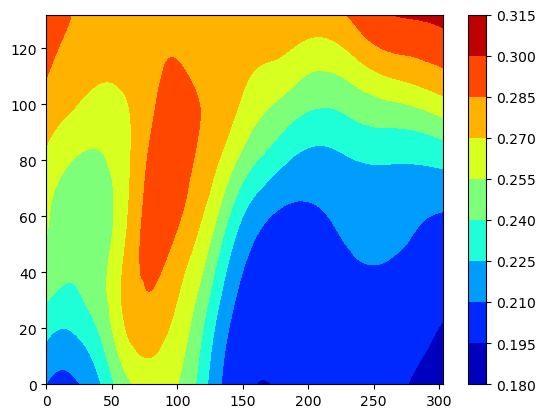

In [109]:
plt.contourf(ws_mean-ws_mean_vec,cmap='jet');plt.colorbar()

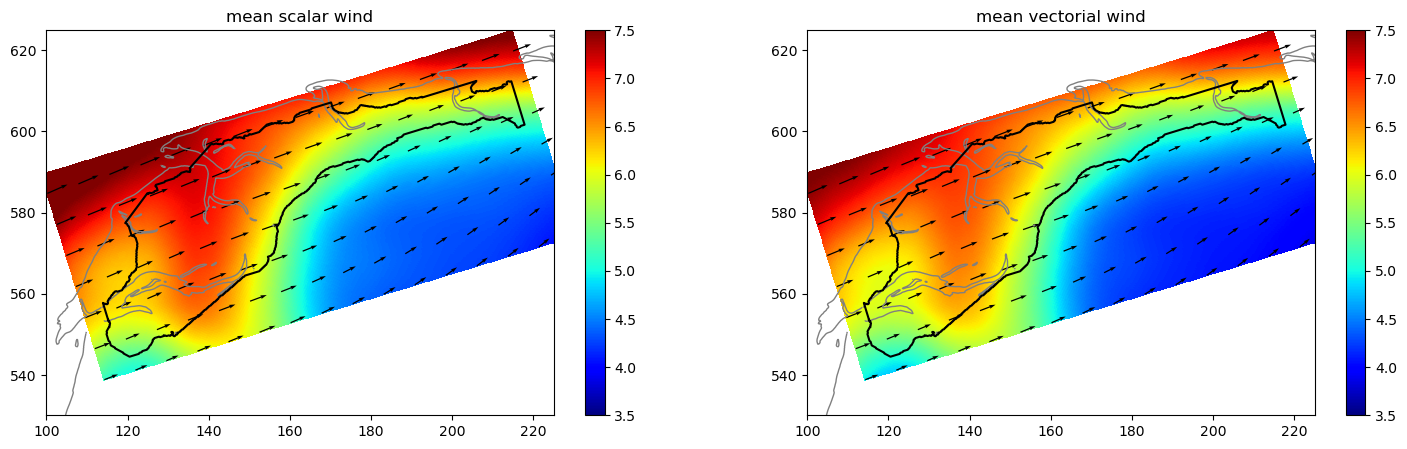

In [33]:
ws_mean_u10p,ws_mean_v10p=projection_to_model_local_coords(ws_mean_u10,ws_mean_v10,ang=-17*np.pi/180)
ws_mean_vec_u10p,ws_mean_vec_v10p=projection_to_model_local_coords(ws_mean_vec_u10,ws_mean_vec_v10,ang=-17*np.pi/180)

fig,ax= plt.subplots(1,2,figsize=(18,5))
iyy=20;ixx=20
units='width';width=0.0025;scale=50
aa=ax[0].pcolormesh(xcdisp,ycdisp,ws_mean,vmin=3.5,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0].quiver(xcdisp[::iyy,::ixx],ycdisp[::iyy,::ixx],ws_mean_u10p[::iyy,::ixx],ws_mean_v10p[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax[0].axis('equal');ax[0].axis([100,225,540,615])
plt.colorbar(aa,ax=ax[0])
ax[0].set_title('mean scalar wind')
aa=ax[1].pcolormesh(xcdisp,ycdisp,ws_mean_vec,vmin=3.5,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1].quiver(xcdisp[::iyy,::ixx],ycdisp[::iyy,::ixx],ws_mean_vec_u10p[::iyy,::ixx],ws_mean_vec_v10p[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax[1].axis('equal');ax[1].axis([100,225,540,615])
plt.colorbar(aa,ax=ax[1])
ax[1].set_title('mean vectorial wind');

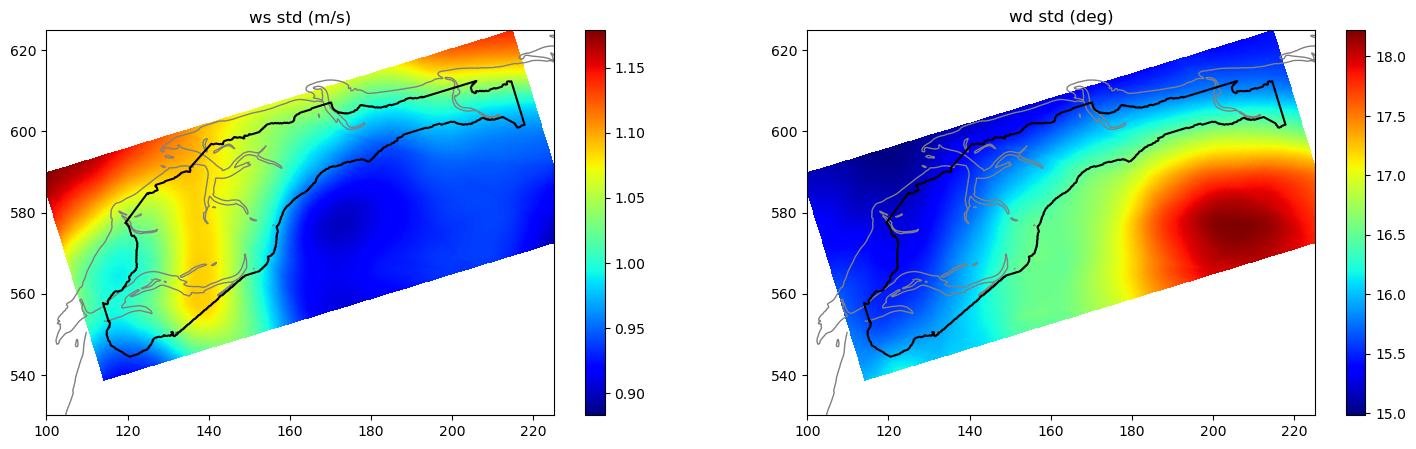

In [36]:
fig,ax= plt.subplots(1,2,figsize=(18,5))
iyy=20;ixx=20
units='width';width=0.0025;scale=50
aa=ax[0].pcolormesh(xcdisp,ycdisp,ws_mean_std,shading='auto',cmap='jet') #wind correct orientation
ax[0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0].axis('equal');ax[0].axis([100,225,540,615])
plt.colorbar(aa,ax=ax[0])
ax[0].set_title('ws std (m/s)')
aa=ax[1].pcolormesh(xcdisp,ycdisp,wd_mean_std*180/np.pi,shading='auto',cmap='jet') #wind correct orientation
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1].axis('equal');ax[1].axis([100,225,540,615])
plt.colorbar(aa,ax=ax[1])
ax[1].set_title('wd std (deg)');